In [1]:
import sys
import os
sys.path.insert(0, "../../python")
sys.path.insert(0, "../../litos")

import numpy as np
import particle_beam as pb
import plasma_source as ps
import particle_beam_propagation as pbp
import scipy.constants as const

import numpy as np
from beam.beams import electronbeam
import matplotlib.pyplot as plt
from beam import interactions
from ionization import ionization
from lens import profile

path = '/media/robert/Data_Storage/Data/Matched-Accelerating-Gradient/Beam_Size_vs_Density/'

In [2]:
# Run Mike's code to see what it does
# define plasma bulk (flat-top) properties
npl0   = 5e16 # cm^-3
dEds0  = np.sqrt(npl0/(1e17))*10e9 # eV/m
dgds0  = dEds0/0.511e6
L_ft   = 0.1 # m

# define plasma up-ramp
shape_up = 'gauss'
hw_up    = 0.1325 #0.05 # m
L_up     = 1.5 # m
top_up   = L_up # m

# define plasma down-ramp
shape_dn = shape_up
hw_dn    = hw_up # m
L_dn     = 0.0 # m
top_dn   = 0  # m

# define beam parameters
gbC    = 20000 # relativistic lorentz factor
eps    = 5.3e-6  # m-rad, normalized emittance
beta   = 0.10  # m

alpha  = 0.00
gamma  = (1.0+alpha**2)/beta # 1/m
dgb    = 0.01
dz     = 0
npart  = 10000
dist   = 'gauss'

# make beam
s0     = 0.0
twiss = pb.make_twiss(beta,alpha,gamma,eps,gbC,dgb,dz)
parts = pb.make_parts(twiss[0],npart,dist)
ebeam = pb.make_ebeam(s0,twiss[0],parts[0])

# add offset to bunch at vac. waist
#ebeam[0]["x"] += 10e-6 # m

# set beam waist position
waist = -0.36 #-0.105 # m, waist location w.r.t L_up
s_w   = L_up + waist # m

# define longitudinal steps
wp0    = (5.64e4)*np.sqrt(npl0) # rad/s, plasma ang. freq.
kp0    = wp0/const.c # m^-1, plasma wave number
kb     = kp0/np.sqrt(2*gbC)

ds   = (1.0/kb)*(1./10.) # m
print(ds)
s_ft = np.linspace(0,L_ft,int(L_ft/ds+1))
s_up = np.linspace(0,L_up,int(L_up/ds+1))
s_dn = np.linspace(0,L_dn,int(L_dn/ds+1))

# make plasma
bulk    = ps.make_bulk(s_ft,npl0,dgds0)
up_ramp = ps.make_ramp(s_up,'up',shape_up,hw_up,top_up,npl0,dgds0)
dn_ramp = ps.make_ramp(s_dn,'dn',shape_dn,hw_dn,top_dn,npl0,dgds0)
plasma  = ps.make_plasma(bulk,up_ramp,dn_ramp)

# propagate beam backward from waist to start of plasma
pbp.prop_ebeam_drift(ebeam,[0,-s_w],last_only=True)
twiss = pb.get_twiss(ebeam,len(ebeam)-1)
parts = pb.get_parts(ebeam,len(ebeam)-1)
ebeam = pb.make_ebeam(s0,twiss[len(ebeam)-1],parts[len(ebeam)-1])
vbeam = ebeam.copy()

# propagate beam through plasma
#pbp.prop_ebeam_plasma(ebeam,plasma,last_only=False)

# propagate beam through vacuum
#pbp.prop_ebeam_drift(vbeam,plasma["s"],last_only=False)

0.000475430010801


In [3]:
z = plasma['s']*1e6
ne = plasma['npl']/1e17
print('Nz:', len(z))
print('dgds0:', dgds0)

Nz: 3366
dgds0: 13837.7060898


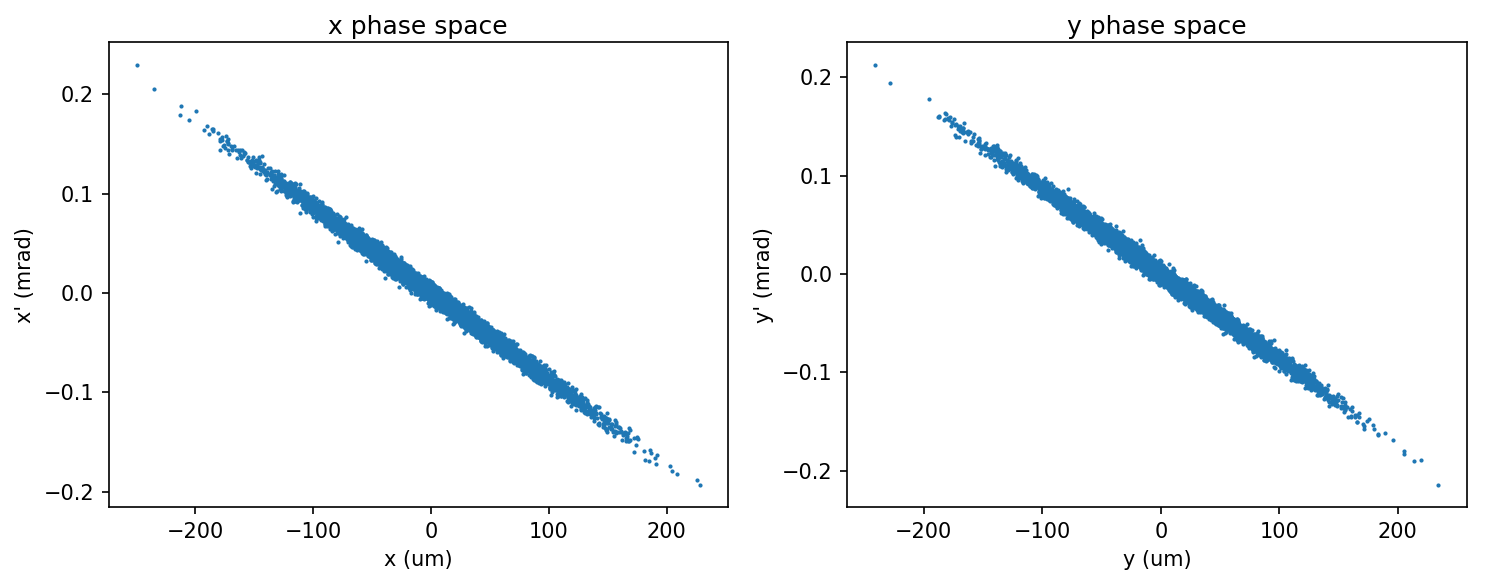

In [4]:
# Now we can test my code and see if it is different
betaBeam = beta+(-s_w)**2/beta
alphaBeam = s_w/beta
electronParams = {
    'name' : 'TestBeam',
    'path' : path,
    'load' : False,
    'N' : npart,
    'gamma' : gbC,
    'emittance' : eps,
    'betax' : betaBeam,
    'betay' : betaBeam,
    'alphax' : alphaBeam,
    'alphay' : alphaBeam,
    'sigmaz' : 5e-6,
    'dE' : 0.01
}

beam = electronbeam.GaussianElectronBeam(electronParams)
beam.plot_current_phase()

class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return ne
    def dgammadz(self, ne):
        npl = ne*1e17
        if npl > ((4/9)*npl0):
            dgdz = dgds0*np.sqrt(npl/npl0)*(3*np.sqrt(npl/npl0)-2)
        else:
            dgdz = (-dgds0)*(2/np.pi)*np.sqrt(npl/npl0)*np.sin((3*np.pi/2)*np.sqrt(npl/npl0))
        return dgdz*1e-6
    
plasmaDen = plasmaCls()
interactions.electron_plasma(beam, plasmaDen, z, 1, 4)

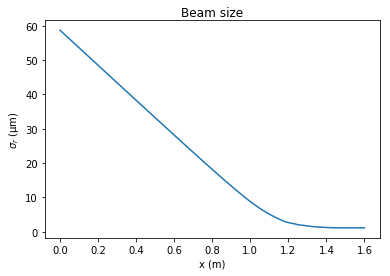

In [5]:
beam_sigmar = np.zeros(len(z), dtype='double')
for i in range(len(z)):
    beam_sigmar[i] = np.average(beam.get_sigmar(i))
plt.plot(z/1e6, beam_sigmar*1e6)
plt.title('Beam size')
plt.xlabel('x (m)')
plt.ylabel(r'$\sigma_r$ ($\mathrm{\mu m}$)')
plt.show()

In [6]:
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec
plt.style.use('notes')
beam_sigmar = np.zeros(len(z), dtype='double')
for i in range(len(z)):
    beam_sigmar[i] = np.average(beam.get_sigmar(i))

eps0 = const.physical_constants['electric constant'][0]
me = const.physical_constants['electron mass'][0]
e = const.physical_constants['elementary charge'][0]
c = const.physical_constants['speed of light in vacuum'][0]
gamma = 20000
sigmaM = np.sqrt(c*np.sqrt(me*eps0/ne/1e23/e**2)*1e6*np.sqrt(2*gamma)*5.3/gamma)

plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0,0])
plt.plot(ne, beam_sigmar*1e6)
plt.plot(ne, sigmaM)
plt.title('Drive beam size')
plt.xlabel(r'$n_e$ ($10^{16}\,\mathrm{cm^{-3}}$)')
plt.ylabel(r'$\sigma_r$ ($\mathrm{\mu m}$)')
plt.legend(['Beam propagation', 'Matched beam'])
plt.xlim([0.01, 0.5])
plt.ylim([0, 3])

sigmar = interp1d(ne, beam_sigmar*1e6)
nx = np.array([0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01])
sigmarx = sigmar(nx)
print(nx)
print(sigmarx)

[ 0.5    0.25   0.1    0.075  0.05   0.025  0.01 ]
[ 1.13625739  1.33980051  1.6370931   1.84069314  1.94393821  2.41164003
  2.87989111]


In [7]:
eps    = 7e-6
# Now we can test my code and see if it is different
betaBeam = beta+(-s_w)**2/beta
alphaBeam = s_w/beta
electronParams = {
    'name' : 'TestBeam',
    'path' : path,
    'load' : False,
    'N' : npart,
    'gamma' : gbC,
    'emittance' : eps,
    'betax' : betaBeam,
    'betay' : betaBeam,
    'alphax' : alphaBeam,
    'alphay' : alphaBeam,
    'sigmaz' : 5e-6,
    'dE' : 0.01
}

beam = electronbeam.GaussianElectronBeam(electronParams)

class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return ne
    def dgammadz(self, ne):
        npl = ne*1e17
        if npl > ((4/9)*npl0):
            dgdz = dgds0*np.sqrt(npl/npl0)*(3*np.sqrt(npl/npl0)-2)
        else:
            dgdz = (-dgds0)*(2/np.pi)*np.sqrt(npl/npl0)*np.sin((3*np.pi/2)*np.sqrt(npl/npl0))
        return dgdz*1e-6
    
plasmaDen = plasmaCls()
interactions.electron_plasma(beam, plasmaDen, z, 1, 4)

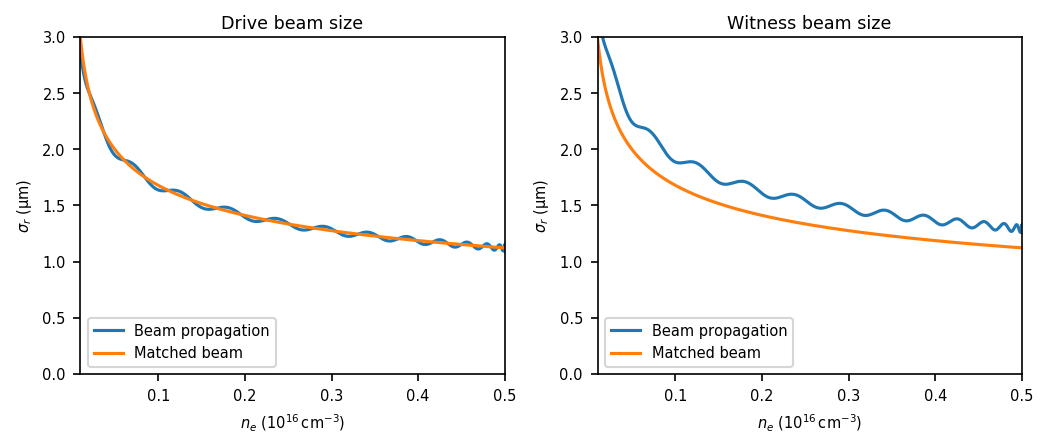

[ 0.5    0.25   0.1    0.075  0.05   0.025  0.01 ]
[ 1.31298296  1.5455148   1.88558797  2.12585105  2.23897571  2.78493463
  3.31744222]


In [8]:
beam_sigmar = np.zeros(len(z), dtype='double')
for i in range(len(z)):
    beam_sigmar[i] = np.average(beam.get_sigmar(i))

plt.subplot(gs[0,1])
plt.plot(ne, beam_sigmar*1e6)
plt.plot(ne, sigmaM)
plt.title('Witness beam size')
plt.xlabel(r'$n_e$ ($10^{16}\,\mathrm{cm^{-3}}$)')
plt.ylabel(r'$\sigma_r$ ($\mathrm{\mu m}$)')
plt.legend(['Beam propagation', 'Matched beam'])
plt.xlim([0.01, 0.5])
plt.ylim([0, 3])
plt.tight_layout()
plt.show()

sigmar = interp1d(ne, beam_sigmar*1e6)
nx = np.array([0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01])
sigmarx = sigmar(nx)
print(nx)
print(sigmarx)